### FF network using pytorch tensors, autograd.

**torch.nn** - has functional, linear, sequential, optimizer  
(neural n/w abstractions)

make code more compact, efficient, easier to read, maintain.

efficient, clean way to write code.  
make benifit of all the libraries.(to work with DL at scale.)

In [1]:
import torch

import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(0) #torch seed for random

#### data(blob)

In [3]:
# data

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)

XX_train, XX_val, Y_train, Y_val = train_test_split(data, labels, 
                                                  stratify=labels, random_state=0)
print(XX_train.shape, XX_val.shape, labels.shape)

(750, 2) (250, 2) (1000,)


#### data as torch tensors

In [4]:
XX_train, Y_train, XX_val, Y_val = map(torch.tensor, (XX_train, Y_train, XX_val, Y_val)) 

# map the function to all and return all. - instead of calling on each one by one.
# making torch tensors from those ndarrays. (not same memory)

print(XX_train.shape, Y_train.shape)

torch.Size([750, 2]) torch.Size([750])


In [5]:
XX_train = XX_train.float()
Y_train = Y_train.long()  # as its an index.

**all data, parameters, .. be torch tensors**

**Using torch tensor, autograd manaully.**

##### Forward pass

In [6]:
# forward prop given input. return ouput.

# XX - a single datapoint(tensor) 
# or all datapoints(tensor)-in that case returned o/p will be a set of outputs for each.(tensor)


def model(XX):
    AA1 = torch.matmul(XX, Wmat1) + Bvec1  # (N, 2) x (2, 2) -> (N, 2)
    HH1 = AA1.sigmoid()  # (N, 2)
    # sigmoid - torch fn that can be called on a tensor.

    AA2 = torch.matmul(HH1, Wmat2) + Bvec2  # (N, 2) x (2, 4) -> (N, 4)

    # softmax layer => softmax on preactivation values

    # softmax
    HH2 = AA2.exp() / AA2.exp().sum(-1).unsqueeze(-1)  # (N, 4)
    # chaining way.
    # exp() - exponential on each element.
    # sum(which axis)  '-1' -> sum along last dimension.

    # what sum returns will be one dimension lesser than the input. 
    # eg: if input is 3D tensor, sum gives 2D tensor
    # this causes a dimension mismatch in the division opearaion.

    # therefore we add back the dimension we lost while using sum 
    # - using the unsqueeze function.

    # add dimension to -1 position - as that is where we took sum.

    # unsqueeze -> add a dimension in the specified axis
    # -1 => add dimension in last

    return HH2

functions on tensors (like sigmoid, exp, .. ); usual syntax:  
**tensor.function()**

**axis** => on which axis/ along which axis  
-1  => first axis from last  

**most functions take axis as argument - do along the specified axis**  
eg: sum(axis)  

**unsqueeze(axis)** => add a 1 in the "dimension" - in the specified position(axis).   

eg : doing sum along an axis - the result will be one dimension less than the original. This might casue of dimension mismatch - to avoid this we - add back the dimension at that axis - using unsqueeze.  
looks same - only some extra brackets there.

In [7]:
#unsqueeze

A3 = torch.ones(5,2,3)
print(A3.shape)
print(A3.unsqueeze(1).shape)
print(A3.unsqueeze(-1).shape)

torch.Size([5, 2, 3])
torch.Size([5, 1, 2, 3])
torch.Size([5, 2, 3, 1])


**chaining functions**  
calling one returns a tensor, on which another one can be called, and so on..   
this makes code easier to follow and maintain(can understand what is going on easily)

##### Loss

In [8]:
# loss function

# cross entropy loss
# -log(prob corresponding to the true one)
# sum of such for all datapoints (sum or mean)

# Y_hat = probability distribution
# y = true 'label' (NOT one-hot)

def loss_fn(YY_hat, yy):
    return -( YY_hat[ range(yy.shape[0]), yy ].log() ).mean()


# element at 'y' position from each Y_hat
# y_hat - N x classes
# Y_hat[range(YY_hat.shape[0]), yy]  -> y-th in each row.

tensor\[ list_x, list_y ] - all element-wise-'pair'-coordinates from the two lists   

tensor[:, list] - all possible combinations

In [9]:
check = torch.tensor([[0.1, 0.2, 0.3, 0.4], [0.8, 0.1, 0.05, 0.05]])

print( check[ [0,1],[0,2] ] )  # access (0,0), (1,2) - element wise pairs

print( check[ : , [0,2] ] ) # access (*,0), (*,2)

tensor([0.1000, 0.0500])
tensor([[0.1000, 0.3000],
        [0.8000, 0.0500]])


##### Accuracy(evaluation)

In [10]:
def accuracy(YY_hat, yy):
    pp = torch.argmax(YY_hat, dim=1) #prediction = max probability
    return (pp == yy).float().mean()


# .float() convert to float.
# pred==y -> bool of correct preds.

#### parameters

In [11]:
# initialize weights(xavier)

torch.manual_seed(0)

Wmat1 = torch.randn(2, 2) / np.sqrt(2)
Wmat1.requires_grad_()  # enabling gradient after making tensor.
# in place
Bvec1 = torch.zeros(2, requires_grad=True)

Wmat2 = torch.randn(2, 4) / np.sqrt(2)
Wmat2.requires_grad_()
Bvec2 = torch.zeros(4, requires_grad=True)

# require grad - set. as we want derviatives wrt the parameters

In [12]:
# here these parameters are like global variables. 
# They are accessed in the forward pass function , .. 

##### Fit

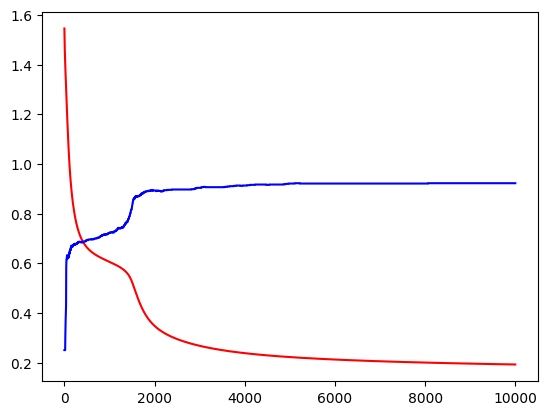

Loss before training:  1.5456440448760986
Loss after training:  0.19288595020771027


In [13]:
learning_rate = 0.2
epochs = 10000

# book keeping
loss_arr = []
acc_arr = []

# each epoch:
for epoch in range(epochs):
    
    # forward prop - called on whole train dataset.
    YY_hat = model(XX_train)
    # YY_hat is series of output of each. N x o/p dim
    
    # loss 'variable':
    loss = loss_fn(YY_hat, Y_train)  
    # need this line as here is the loss-variable made
    
    # gradient on loss.
    loss.backward()
    
    # logging loss, accuracy - per epoch
    loss_arr.append(loss.item())  # item gives the value.
    acc_arr.append(accuracy(YY_hat, Y_train))

    # updating parameters
    with torch.no_grad():  # so that not treated as new variables
        Wmat1 -= Wmat1.grad * learning_rate
        Bvec1 -= Bvec1.grad * learning_rate
        Wmat2 -= Wmat2.grad * learning_rate
        Bvec2 -= Bvec2.grad * learning_rate

        # make gradients 0.
        Wmat1.grad.zero_()
        Bvec1.grad.zero_()
        Wmat2.grad.zero_()
        Bvec2.grad.zero_()

# plot the logged error, accuracy
# vs epoch
plt.plot(loss_arr, "r-")
plt.plot(acc_arr, "b-")
plt.show()

print("Loss before training: ", loss_arr[0])
print("Loss after training: ", loss_arr[-1])

above - manually using tensor. vectorised code, plus BP using backward.